In [62]:
import z3
from z3 import Solver, Const, Int, Real, EnumSort, sat
import LOTlib3
from LOTlib3.Grammar import Grammar
from LOTlib3.Eval import primitive
from LOTlib3.Hypotheses.LOTHypothesis import LOTHypothesis
from LOTlib3.Hypotheses.Likelihoods.BinaryLikelihood import BinaryLikelihood
from LOTlib3.TopN import TopN
from LOTlib3.DataAndObjects import FunctionData
import numpy as np
from functools import cache

import builtins

from copy import copy, deepcopy
from itertools import product
from pprint import pprint

from functools import reduce

%load_ext line_profiler

import functions

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [63]:
from importlib import reload
reload(functions)

already defined!


<module 'functions' from '/mnt/c/Users/faust/OneDrive - UvA/research_projects/2024_pLoTRSA/functions.py'>

In [ ]:
m = functions.BooleanModel()
qud = functions.QUD([
    z3.And(m.q, m.p), 
    z3.And(z3.Not(m.q), m.p),
    z3.And(m.q, z3.Not(m.p)),
    z3.And(z3.Not(m.q), z3.Not(m.p))
])

In [178]:
grammar_phon = functions.define_grammar(False)
grammar_utt = functions.define_grammar(True)

phon = grammar_phon.generate()
print(phon)

ifthen(q(M), p(M))


In [179]:
exhaustifier = functions.Exhaustifier(
    grammar_utt,
    qud
)

In [186]:
possible_utts = functions.produce_possible_structures(phon, grammar=grammar_phon)

In [187]:
possible_utts

[ifthen(q(M), p(M)),
 EXH(ifthen(q(M), p(M))),
 ifthen(EXH(q(M)), p(M)),
 ifthen(q(M), EXH(p(M)))]

In [188]:
x = possible_utts[1]

In [191]:
x1 = functions.Utterance(qud, value=x)

In [193]:
x1()

And(Implies(q, p),
    Not(And(p, q)),
    Not(q),
    Not(And(q, p)),
    Not(And(q, q)),
    Not(Or(q, q)))

In [182]:
exhaustified = exhaustifier.exhaustify(
    possible_utts[1],
    m
)

In [183]:
exhaustified

And(Implies(q, p),
    Not(And(p, q)),
    Not(q),
    Not(And(q, p)),
    Not(And(q, q)),
    Not(Or(q, q)))

In [185]:
s = z3.Solver()
s.add(exhaustified)
for i in functions.all_smt(s, [m.p, m.q]):
    print(i)

[p = False, q = False]
[q = False, p = True]


In [176]:
hs = [ 
    z3.simplify(functions.Utterance(qud, value=utt)()) 
    for utt in possible_utts
]

innocently excludable: [Not(p), Not(And(q, p)), Not(And(p, q))]
innocently excludable: []
innocently excludable: [Not(p)]


In [114]:
hs

[Or(p, q),
 And(Or(p, q), Not(And(q, p)), Not(And(p, q))),
 Or(q, And(p, Not(q))),
 Or(p, And(q, Not(p)))]

In [128]:
simplified = hs[2]

In [129]:
simplified.sexpr()

'(or q (and p |Not(q)|))'

In [132]:
s = z3.Solver()
s.add(simplified)
s.check()
s.model()

[q = False, p = True, Not(q) = True]

In [182]:
p, q = z3.Bools('p q')

hard = z3.Or(q, p)
soft = [p, z3.Not(z3.And(p, q))]

solver = functions.MSSSolver(hard, soft)     
mms = tuple(functions.enumerate_sets(solver))
intersection = reduce(lambda x, y: x & set(y), mms, set(mms[0]))
print(mms)
print(intersection)

v:  p
v:  |Not(And(p, q))|
([p, Not(And(p, q))],)
{p, Not(And(p, q))}


In [151]:
print(intersection)

{Or(p, q), Not(And(q, p)), Not(And(p, q))}


In [183]:
s = z3.Solver()
s.add(list(intersection)[1])
s.add(p)
s.add(q)
if s.check():
    print(s.model())

[p = True, q = True, Not(And(p, q)) = True]


In [159]:
ex = list(intersection)[1]

In [161]:
ex.children()

[]

In [162]:
ex1 = z3.Not(z3.And(q, p))

In [163]:
ex1.children()

[And(q, p)]

In [180]:
s = z3.Solver()
p, q = z3.Bools('p q')
s.add({z3.Or(p, q), z3.Not(z3.And(q, p))})
for i in functions.all_smt(s, [p, q]):
    print(i)

[q = True, p = False]
[p = True, q = False]


In [144]:
z3.Not(z3.And(q, p)).sexpr()

'(not (and q p))'

In [148]:
print([x.sexpr() for x in intersection])
print([x.sexpr() for x in {z3.Or(p, q), z3.Not(z3.And(q, p)), z3.Not(z3.And(p, q))}])

['|Or(p, q)|', '|Not(And(q, p))|', '|Not(And(p, q))|']
['(not (and p q))', '(not (and q p))', '(or p q)']


In [181]:
print(intersection, '\n')
s = z3.Solver()
s.add(intersection)
for i in functions.all_smt(s, [p, q]):
    print(i)

{Not(And(p, q))} 

[Not(And(p, q)) = True]
[p = True, Not(And(p, q)) = True]
[p = True, q = True, Not(And(p, q)) = True]
[q = True, p = False, Not(And(p, q)) = True]


# Plot

In [181]:
def plot_hasse_diagram(expressions):
    
    # Define propositional variables
    p, q = z3.Bools('p q')
    variables = [p, q]

    # Generate all possible truth assignments for the variables
    truth_assignments = [
        {p: True, q: True},
        {p: True, q: False},
        {p: False, q: True},
        {p: False, q: False}
    ]

    # Define positions for a fixed layout (False, False at the bottom)
    positions = {
        0: (1, 2),  # True, True
        1: (0, 1),  # True, False
        2: (2, 1),  # False, True
        3: (1, 0)   # False, False
    }

    # Plotting each expression's Hasse diagram
    for idx, expr in enumerate(expressions):
        # Evaluate expression for each truth assignment
        evaluations = []
        for assignment in truth_assignments:
            s = z3.Solver()
            for var, val in assignment.items():
                s.add(var == val)
            s.add(expr)
            print(assignment, expr)
            if s.check() == z3.sat:
                print(s.model())
            if s.check() == z3.sat:
                evaluations.append(True)
            else:
                evaluations.append(False)

        # Create a graph for the Hasse diagram
        G = nx.DiGraph()

        # Add nodes with color based on evaluation
        for i, eval in enumerate(evaluations):
            color = 'green' if eval else 'red'
            G.add_node(i, label=str(truth_assignments[i]), color=color)

        # Add edges based on logical implication (order must be maintained)
        G.add_edges_from([(1, 0), (2, 0), (3, 1), (3, 2)])

        # Draw the graph
        colors = nx.get_node_attributes(G, 'color').values()
        labels = nx.get_node_attributes(G, 'label')
        nx.draw(G, pos=positions, labels=labels, node_color=colors, with_labels=True)
        plt.title(f"Expression {idx+1}: {expr}")
        plt.show()

In [199]:
hs[1].sexpr()

'(and (or p q) |Not(And(q, p))| |Not(And(p, q))|)'

In [193]:
s = z3.Solver()
for i in functions.all_smt(s, [hs[1]]):
    print(i)

[]
[p = True, Not(And(q, p)) = True, Not(And(p, q)) = True]


In [200]:
p, q = Bools('p q')
s = Solver()
expr = And(Or(p, q), Not(And(q, p)), Not(And(p, q)))
s.add(expr)

for m in functions.all_smt(s, [p, q]):
    print(m)

[p = True, q = False]
[p = False, q = True]


In [201]:
expr.sexpr()

'(and (or p q) (not (and q p)) (not (and p q)))'

{p: True, q: True} Or(p, q)
[p = True, q = True]
{p: True, q: False} Or(p, q)
[p = True, q = False]
{p: False, q: True} Or(p, q)
[p = False, q = True]
{p: False, q: False} Or(p, q)


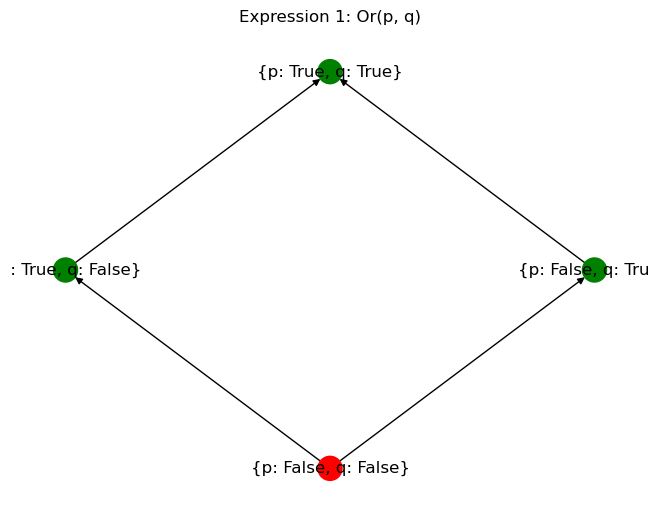

{p: True, q: True} And(Or(p, q), Not(And(q, p)), Not(And(p, q)))
[p = True,
 q = True,
 Not(And(q, p)) = True,
 Not(And(p, q)) = True]
{p: True, q: False} And(Or(p, q), Not(And(q, p)), Not(And(p, q)))
[p = True,
 q = False,
 Not(And(q, p)) = True,
 Not(And(p, q)) = True]
{p: False, q: True} And(Or(p, q), Not(And(q, p)), Not(And(p, q)))
[p = False,
 q = True,
 Not(And(q, p)) = True,
 Not(And(p, q)) = True]
{p: False, q: False} And(Or(p, q), Not(And(q, p)), Not(And(p, q)))


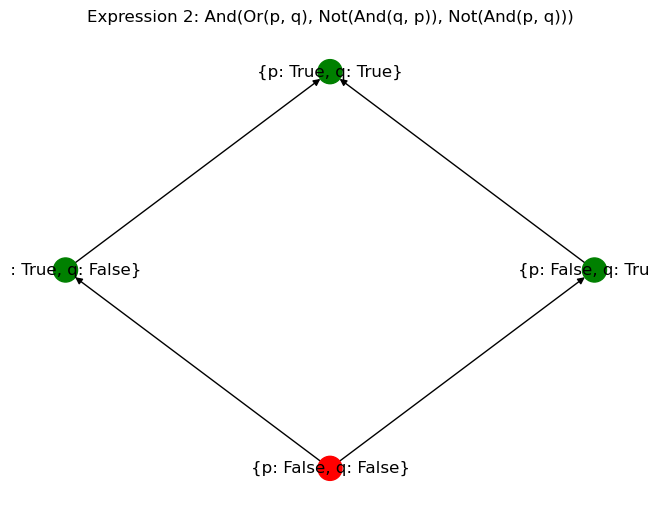

{p: True, q: True} Or(p, And(q, Not(p)))
[p = True, q = True, Not(p) = True]
{p: True, q: False} Or(p, And(q, Not(p)))
[p = True, q = False, Not(p) = False]
{p: False, q: True} Or(p, And(q, Not(p)))
[p = False, q = True, Not(p) = True]
{p: False, q: False} Or(p, And(q, Not(p)))


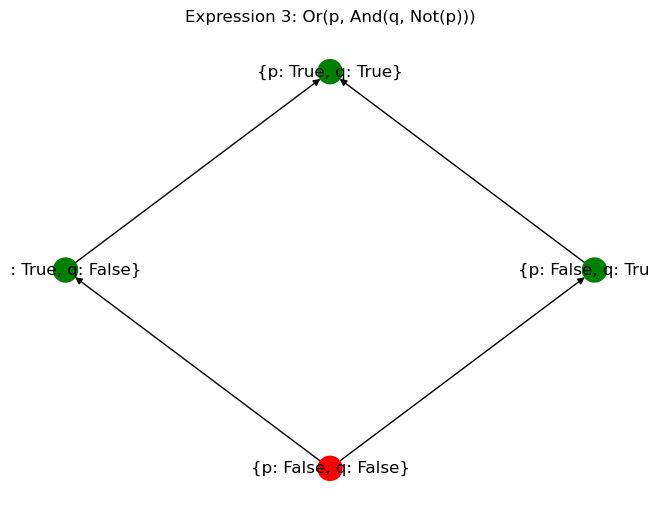

{p: True, q: True} Or(q, And(p, Not(q)))
[p = True, q = True, Not(q) = True]
{p: True, q: False} Or(q, And(p, Not(q)))
[p = True, q = False, Not(q) = True]
{p: False, q: True} Or(q, And(p, Not(q)))
[p = False, q = True, Not(q) = False]
{p: False, q: False} Or(q, And(p, Not(q)))


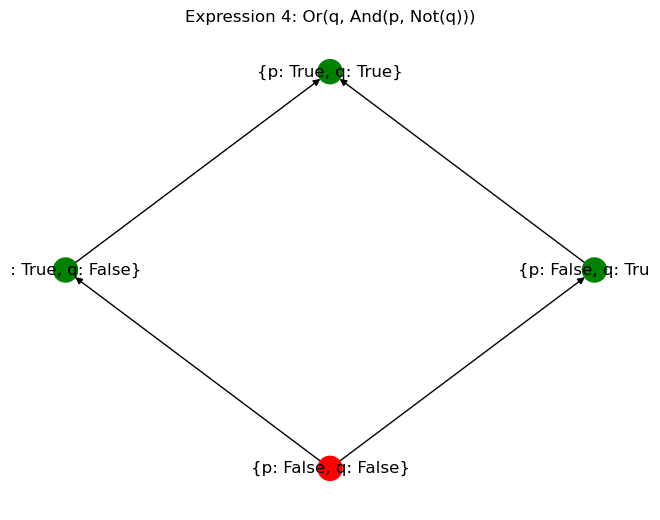

In [182]:
plot_hasse_diagram(hs)

# RSA

The listener computes a joint distribution over QUD-relevant belief states $o$ and possible utterances $u$ given the phonological form $\phi$ (a (partial) answer to the QUD can in principle be inferred from the utterance). We assume a silent EXH operator that does not show in $\phi$ but might be part of $u$. Call $\forall_{EXH}(\phi)$ the set of all utterances compatible with $\phi$.
\begin{align}
P_{L1}(o \mid \phi)
&= \sum_{u \in UTT} P_{L1}(o, u \mid \phi) \\
&= \sum_{u \in UTT} P_{L1}(u \mid \phi)P_{L1}(o \mid u, \phi) \\
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{L1}(o \mid u, \phi) & P_{L1}(u \mid \phi) \text{ has uniform prob among compatible \& 0 otherwise} \\
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{L1}(o \mid u ) & \text{since $o$ is independent of $\phi$ given $u$} 
\end{align}

At this point we need a way of computing $P_{L1}(o \mid u)$: how probable for the listener is meaning $o$ given utterance $u$? There are many solutions, but here are two:
1. Assume an $S_0$ that samples an utterance uniformly from utterances compatible with the meaning.
2. Assume that the speaker tends to produce an utterance that is more relevant given the QUD. The possible utterances here are the possible parses of the phonological form (given by the various ways of inserting EXH):

\begin{align}
&= \frac{1}{|\forall_{EXH}(\phi)|} \sum_{u \in \forall_{EXH}(\phi)} P_{S1}( [\![ u ]\!] \mid o) P_{L1}(o) K & \text{Bayes' theorem.}
\end{align}

Some points:
- Sample $o$ w/ LOTlib, check with z3 that $o$ is consistent with $u$ (else return -inf), and if so calculate the actual quantities.
- This assumes DAG $o \rightarrow u \rightarrow \phi$, but in future the communicative intention $i$ could be added ($o \rightarrow i \rightarrow u \rightarrow \phi$), which can depend on the speaker's goals independently of the QUD.

At this point we have three components to unpack:
- $\forall_{EXH}(\phi)$
  - The set of utterances compatible with the given phonological form.
- $P_{S1}([\![ u ]\!] \mid o) \propto \texttt{softmax}_\lambda \text{KL}\left( P_{S1}( A \mid o) ||  P_{L0}( A | u ) \right)$
    - The (normalized) probability that the speaker will choose an utterance given an observation.
    - The speaker's goal is to answer the QUD as well as possible, and this is of course a function of the meaning of the utterance.
    - $A$ is the random variable "Answer to the QUD"
    - Calculating $P_{S1}( A \mid o)$:
        - The probability of each answer is proportional to the number of models compatible with $o$ that belong to that answer.
    - Calculating $P_{L0}( A | u )) $:
        - In theory, the normalization constant of $P_{L0}(A \mid u)$ is a sum over observations
        - However, since there can be infinitely many possible observations in practice I assume that the literal listener uses an approximation:
        - First, we approximate for each answer $a \in A$ how many models are compatible with $a$. For every answer $a$ sample observations that the meaning is compatible with, up to a MAX, e.g., 10. Call this number $\#_a$. This defines a distribution over answers to the QUD given $o$. Since the QUD partitions the possibilities, a singleton $o$ must provide a single answer, but an $o$ with multiple possible worlds (representing uncertainty) could be compatible with multiple answers.
            - If the QUD is yes/no, we recover a discrete approximation of usual RSA $L0$.
            - This means that the speaker only keeps track of a few observations for each answers to the QUD.
        - Compute a discrete approximation to KL divergence.
        - NOTE: Not adding a cost for conceptual complexity yet, but it would relate to the discussion of conceptual complexity by Buccola.
        - The consequence of this term is that listeners will tend to guess an observations fits closely to the meaning. So for instance meaning "a" (compatible with $b$ and $\neg b$)
- $P_{L1}(o)$
    - The probability of the observation. This is just the prior as induced by the pLoT - dealt with by LOTlib3 (but need to redefine the `prior` function otherwise it'll also include complexity of $m$!)
 
Various to note:
- I assume there's an underlying QUD. The agents have some prior distribution over the answers to the QUD, which depends on their world model.
    - The QUD is modelled as a list of z3 objects, one for each answer to the QUD. For instance the QUD "Who is P?" is represented as: `[ And([P(a),P(b)]), P(a), P(b) ]`
    - This is one way to model a partition of the possible worlds.

Examples to explain:
- "Not _p_" -> "p and not q"
- "John talked to Mary or Sue" -> not both (Fox and Spector 2019)
- "Some boys came" -> not all (Fox and Spector 2019)
- "John didn't do the reading OR the homework, he did both" -> not a contradiction! (Fox and Spector 2019)
- "John talked to Mary, or to both Mary and Sue" -> not equivalent to just "Mary" (Trinh 2019)
- Contextual scales:
    - a. A: Do you speak Portuguese? B: My husband's brother does. implicature: B/her husband does not speak Portuguese.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)
- Different focuses:
    - a. A: How many children does Nigel have? B: Nigel has fourteen$_F$ children.
    - b. A: Who has fourteen children? B: Nigel$_F$ has fourteen children.
    - (https://www.tandfonline.com/doi/full/10.1080/0163853X.2017.1316038)

In [ ]:
def PS1_u_m(u, m):
    # probability of an utterance given a meaning
    